In [0]:
import torch

##Check that GPU is available

In [0]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Import Hugging Face Transformers

In [0]:
!pip install transformers

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import AdamW, RobertaForSequenceClassification, RobertaTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import random
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pull data from git repo (the repo has to be public to allow for accessing individual files)

In [0]:
!curl -o test.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/324252a5e6c5beabb1bdf174c38b0899dcf31438/data/test.csv
!curl -o train.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/324252a5e6c5beabb1bdf174c38b0899dcf31438/data/train.csv
!curl -o validate.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/324252a5e6c5beabb1bdf174c38b0899dcf31438/data/validate.csv

#!curl -o test_scrubbed.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/f75198ebabe3db8ca7e05692b543136b42bfd08a/data/test_scrubbed.csv
#!curl -o train_scrubbed.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/f75198ebabe3db8ca7e05692b543136b42bfd08a/data/train_scrubbed.csv
#!curl -o validate_scrubbed.csv https://bitbucket.org/jtfitzpa/eecs595_project/raw/f75198ebabe3db8ca7e05692b543136b42bfd08a/data/validate_scrubbed.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.3M  100 22.3M    0     0  5120k      0  0:00:04  0:00:04 --:--:-- 5120k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178M  100  178M    0     0  6101k      0  0:00:29  0:00:29 --:--:-- 9440k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.3M  100 22.3M    0     0  4163k      0  0:00:05  0:00:05 --:--:-- 6081k


# Lyric Dataset Creation Class

In [0]:
class LyricsDatasetCreator:
  """Song lyrics dataset creator class."""

  def __init__(self, labels_num, num_chunks=3):
    self.labels_num = labels_num
    self.num_chunks = num_chunks

  def make_dataset(self, csv_file, dataset_len):
    """
    Function to create a dataset of specified length from the given csv file.
    Args:
        csv_file: Path to the csv file with songs lyrics and genre tags
        labels_num: List of integer labels corresponding to each genre
    Return:
      lyrics: List containing lyrics for each example as a string
      labels: List containing labels for each sample
      num_classes: Number of unique classes in the dataset
    """
    pd_frame = pd.read_csv(csv_file)
    labels = sorted(pd_frame.genre.unique())
    num_classes = len(labels)

    # Replace string labels with numeric labels
    genres = pd_frame.genre.copy()
    new_labels = genres.replace(labels, self.labels_num)
    pd_frame.insert(1, 'label', new_labels) 

    # Create sentence and label lists
    lyrics = pd_frame.lyrics.values
    labels = pd_frame.label.values

    # Split examples to reduce number of tokens per example
    lyrics, labels = self.split_sample(lyrics, labels)

    # Get random sample of length dataset_len
    if dataset_len != -1: # return entire dataset for dataset_len == 1
      idx = random.sample(range(len(labels)), k=dataset_len)
      lyrics = [lyrics[i] for i in idx]
      labels = [labels[i] for i in idx]

    return lyrics, labels, num_classes


  def split_sample(self, lyrics, labels): 
    """
    Split samples in chunks so they are small enough the run though the model.
    Args:
    Return:
    """
    new_lyrics = []
    new_labels = []
    sep = ' '

    for lyric, label in zip(lyrics, labels):
      #for chunk in range(num_chunks):
      seq_len = round(len(lyric.split(sep)) / self.num_chunks)

      for part in self.chunks(lyric.split(sep), seq_len):
        new_lyrics.append(sep.join(part))
        new_labels.append(label)

    return new_lyrics, new_labels


  @staticmethod
  def chunks(l, n):
      """
      Yield successive n-sized chunks from l.
      Args:
        l: List
        n: Chunk size
      Return:
        Chunk of size n from l
      """
      for i in range(0, len(l), n):
          yield l[i:i + n]

# Experiment Runner Class

In [0]:
class RoBERTaExperimentRunner:

  def __init__(self, params, model_file=None):
    """
    Initializer
    Args:
      params: Dictionary of parameters for the experiment
      model_file: Path to load a trained model from
    """
    self.params = params
    self._set_hyperparams()
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pretrained_model = 'roberta-base'
    self.tokenizer = RobertaTokenizer.from_pretrained(pretrained_model, do_lower_case=True, do_basic_tokenize=True)
    self.load_dataset()

    # Load existing model or instantiate new one
    self.model = RobertaForSequenceClassification.from_pretrained(pretrained_model,
                                                               num_labels=self.num_classes)

    if model_file is not None:
      self.load_model(model_file)
    self.model.to(self.device)

    param_optimizer = list(self.model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']

    num_training_steps = round(self.num_train * self.num_epochs / self.batch_size)
    num_warmup_steps = num_training_steps * self.warmup_rate

    self.optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.1},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.0}
        ]

    self.optimizer = AdamW(self.optimizer_grouped_parameters, lr=self.learning_rate)
                           #correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
    #self.scheduler = WarmupLinearSchedule(self.optimizer, self.warmup_rate, num_training_steps)
    self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps, num_training_steps)
    #self.scheduler = WarmupCosineWithHardRestartsSchedule(self.optimizer, self.warmup_rate, num_training_steps)


  def _set_hyperparams(self):
    """
    Set parameters for the experiment.
    Return:
      None
    """
    self.batch_size = self.params['batch_size']
    self.learning_rate = self.params['lr']
    self.num_epochs = self.params['num_epochs']
    self.data_params = self.params['data_params']
    self.num_train = self.data_params['num_train']
    self.num_test = self.data_params['num_test']
    self.num_validation = self.data_params['num_validation']

    self.warmup_rate = self.params['warmup_rate']
    self.max_grad_norm = 1.0
    self.max_seq_length = self.data_params['max_seq_length']


  def load_dataset(self):
    """
    Creates train, test, and validation DataLoaders.
    Return: None
    """
    data_creator = self.data_params['data_creator'] 
    data_paths = self.data_params['data_paths']

    # Training Data
    try:
      train_lyrics, train_labels, self.num_classes = data_creator.make_dataset(data_paths['train'], self.num_train)
    except:
      raise ValueError('Training file path must be provided.')
    
    # Validation Data
    try:
      validation_lyrics, validation_labels, _ = data_creator.make_dataset(data_paths['validate'], self.num_validation)
    except:
      validation_lyrics, validation_labels = None, None

    # Test Data
    try:
      test_lyrics, test_labels, _ = data_creator.make_dataset(data_paths['test'], self.num_test)
    except:
      raise ValueError('Testing file path must be provided.')

    input_ids, train_masks = self.tokenize_lyrics(train_lyrics)
    test_inputs, test_masks = self.tokenize_lyrics(test_lyrics)

    if validation_lyrics is None or validation_labels is None:
      # Use train_test_split to split our data into train and validation sets for training
      test_frac = 0.1
      train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train_labels, 
                                                                  random_state=2018, test_size=test_frac)
      train_masks, validation_masks, _, _ = train_test_split(train_masks, input_ids,
                                                  random_state=2018, test_size=test_frac)
    else:
      train_inputs = input_ids
      validation_inputs, validation_masks = self.tokenize_lyrics(validation_lyrics)      

    # Convert all of our data into torch tensors, the required datatype for our model
    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)
    test_inputs = torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)
    test_labels = torch.tensor(test_labels)
    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)
    test_masks = torch.tensor(test_masks)

    # Create an iterator of our data with torch DataLoader
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    self.train_dataloader = DataLoader(train_data, sampler=train_sampler, 
                                       batch_size=self.batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, 
                                    validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    self.validation_dataloader = DataLoader(validation_data, 
                                            sampler=validation_sampler, 
                                            batch_size=self.batch_size)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = RandomSampler(test_data)
    self.test_dataloader = DataLoader(test_data, sampler=test_sampler, 
                                      batch_size=self.batch_size)


  def tokenize_lyrics(self, lyrics):
    lyrics = [self.tokenizer.cls_token + lyric + self.tokenizer.sep_token for lyric in lyrics]
    tokenized_texts = [self.tokenizer.tokenize(lyric) for lyric in tqdm(lyrics)]

    MAX_LEN = self.max_seq_length

    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [self.tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # Pad our input tokens
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              truncating="post", padding="post")

    attention_masks = self._get_attention_masks(input_ids)

    return input_ids, attention_masks


  @staticmethod
  def _get_attention_masks(input_ids):
    """
    Function to get the attention masks for each input.
    Args:
      input_ids:
    Return:
      attention_masks: List containing 1s for each input token, followed by 0s
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask) 

    return attention_masks


  @staticmethod
  def flat_accuracy(preds, labels):
    """
    Function to calculate the accuracy of our predictions vs labels.
    Args:
      preds: Predicted labels
      labels: Ground truth labels
    Returns:
      Prediction accuracy
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


  def param_count(self):
    """
    Helper function to return count of number of trainable parameters in model.
    Returns:
      Count of trainable parameters in self.model
    """
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)


  def load_model(self, model_file='roberta_model.torch'):
    """
    Load model from disk.
    Args:
      model_file: Path to stored model
    Return: 
      None
    """
    self.model.load_state_dict(torch.load(model_file))


  def save_model(self, model_file='roberta_model.torch'):
    """
    Save model to disk.
    Args:
      model_file: Path to store model
    Return:
      None
    """
    torch.save(self.model.state_dict(), model_file)


  def train(self, freeze_weights=False):
    """
    Run training loop, evaluating on the validation set after each epoch. After
    training is complete, the model is evaluated on the test set.
    Args:
      freeze_weights: If True, only the final classification weights will be trained
    Return:
      train_set_loss: List of losses calculated at each training step
    """

    # Freeze weights
    if freeze_weights:
      for param in self.model.roberta.parameters():
          param.requires_grad = False

    # Store our loss and accuracy for plotting
    train_loss_set = []

    # trange is a tqdm wrapper around the normal python range
    for _ in trange(self.num_epochs, desc="Epoch"):
      
      # Training
      
      # Set our model to training mode (as opposed to evaluation mode)
      self.model.train()
      
      # Tracking variables
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0
      
      # Train the data for one epoch
      for step, batch in enumerate(self.train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        self.optimizer.zero_grad()
        # Forward pass
        model_out = self.model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask, labels=b_labels)
        loss = model_out[0]

        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(self.model.parameters(), 
        #                                self.max_grad_norm)
        # Update parameters and take a step using the computed gradient
        self.optimizer.step()
        self.scheduler.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

      print("Train loss: {}".format(tr_loss/nb_tr_steps))
        
      self.test('train')
      self.test('validation')
      self.save_model() 

    # Get test set accuracy on final model
    self.test('train')
    self.test('test')
    return train_loss_set

  def test(self, mode='validation'):
    """
    Run evaluation in selected mode and prints accuracy.
    Args:
      mode: 'validation', 'train', or 'test' 
    Return: None
    """

    # Put model in evaluation mode to evaluate loss on the validation set
    self.model.eval()

    if mode == 'validation':
      dataloader = self.validation_dataloader
    elif mode == 'test':
      dataloader = self.test_dataloader
    elif mode == 'train':
      dataloader = self.train_dataloader
    else:
      raise ValueError('Vaild modes are \'validation\' and \'test\'')

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in self.validation_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(self.device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
        # Forward pass, calculate logit predictions
        model_out = self.model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = model_out[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = self.flat_accuracy(logits, label_ids)
      
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

    if mode == 'validation':
      print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    elif mode == 'test':
      print("Test Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    elif mode == 'train':
      print("Train Accuracy: {}".format(eval_accuracy/nb_eval_steps))


## Train Model

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

# Run Experiment

In [0]:
genres = ['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock']
labels_num = [0, 1, 2, 3, 4]

num_chunks = 1
data_creator = LyricsDatasetCreator(labels_num, num_chunks)
data_paths = {'train':'train.csv', 'validate':'validate.csv', 'test':'test.csv'}

data_params = {
    'num_train': 1000,
    'num_validation': 500,
    'num_test': 5000,
    'data_paths': data_paths,
    'data_creator': data_creator,
    'max_seq_length': 256,
}

params = {
    # Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
    'batch_size': 32,
    'lr': 2e-5,
    'num_epochs': 10,
    'data_params': data_params,
    'warmup_rate': 0.06,
}

runner = RoBERTaExperimentRunner(params)

100%|██████████| 500/500 [00:00<00:00, 1098.19it/s]


In [0]:
#runner.load_model('roberta_model.torch')

## Parameter Count

In [0]:
runner.param_count()

125240069

In [0]:
train_loss_set = runner.train(freeze_weights=False)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.4623923562467098
Train Accuracy: 0.5046875
Validation Accuracy: 0.5046875


Epoch:  10%|█         | 1/10 [00:34<05:14, 34.96s/it]

Train loss: 1.277074996381998
Train Accuracy: 0.591796875
Validation Accuracy: 0.591796875


Epoch:  20%|██        | 2/10 [01:09<04:39, 34.97s/it]

Train loss: 1.092633968219161
Train Accuracy: 0.6125
Validation Accuracy: 0.6125


Epoch:  30%|███       | 3/10 [01:44<04:04, 34.95s/it]

Train loss: 0.990953654050827
Train Accuracy: 0.56015625
Validation Accuracy: 0.56015625


Epoch:  40%|████      | 4/10 [02:19<03:29, 34.96s/it]

Train loss: 0.8446117136627436
Train Accuracy: 0.63203125
Validation Accuracy: 0.63203125


Epoch:  50%|█████     | 5/10 [02:54<02:54, 34.97s/it]

Train loss: 0.7186213433742523
Train Accuracy: 0.559375
Validation Accuracy: 0.559375


Epoch:  60%|██████    | 6/10 [03:29<02:19, 34.98s/it]

Train loss: 0.5815741438418627
Train Accuracy: 0.601171875
Validation Accuracy: 0.601171875


Epoch:  70%|███████   | 7/10 [04:04<01:44, 34.98s/it]

Train loss: 0.49651698349043727
Train Accuracy: 0.633984375
Validation Accuracy: 0.633984375


Epoch:  80%|████████  | 8/10 [04:39<01:09, 34.98s/it]

Train loss: 0.3863926650956273
Train Accuracy: 0.608984375
Validation Accuracy: 0.608984375


Epoch:  90%|█████████ | 9/10 [05:14<00:34, 34.96s/it]

Train loss: 0.3385850037448108
Train Accuracy: 0.612109375
Validation Accuracy: 0.612109375


Epoch: 100%|██████████| 10/10 [05:49<00:00, 34.93s/it]


Train Accuracy: 0.612109375
Test Accuracy: 0.612109375


## Training Evaluation

Let's take a look at our training loss over all batches:

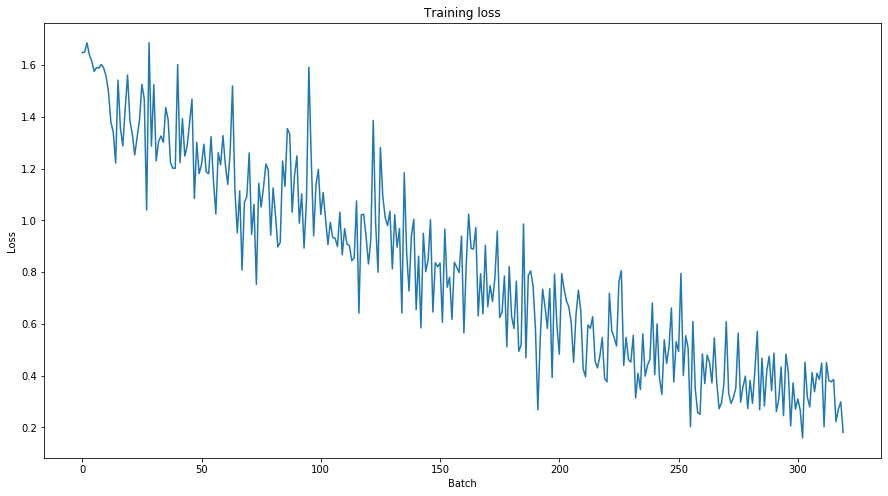

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()